In [719]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pinkrigs_tools.dataset.query import load_data, queryCSV
import os
import glob
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from random import randint
from scipy import stats
from IPython import display


In [837]:

def load_specific_experiment_data(subject_id, date):
    # Load only specified components
    data = load_data(
    subject=subject_id,
    expDate=date,
    data_name_dict= 'all-default',
    )
        
    return data

def get_experiment_path(data):
    exp_idx = data.index[data.expDef.isin(['spontaneousActivity'])][0]
    exp_folder = data.loc[exp_idx, 'expFolder']
    exp_num = data.loc[exp_idx, 'expNum']
    return exp_folder, exp_num

def get_timestamps(subject_id, date, exp_num, exp_folder):
    timestamps_path = fr'ONE_preproc\topCam\camera.times.{date}_{exp_num}_{subject_id}_topCam.npy'
    timestamps= np.load(os.path.join(exp_folder, timestamps_path), allow_pickle=True)
    start_time = np.where(timestamps >=0)[0][0]
    timestamps[:start_time] = np.nan
    timestamps = timestamps.flatten()

    return start_time, timestamps

def calculate_median_position(dlc_df, scorer):

    BODYPARTS = ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3']

    # Group by bodyparts and filter for only the ones we want to use in our calculation
    selected_data = dlc_df.loc[:, (scorer, BODYPARTS, slice(None))]
    

    # Select Values of High Quality
    likelihood_values = selected_data.xs('likelihood', level='coords', axis=1)
    likelihood_values[likelihood_values <= 0.95] = np.nan
    likelihood_values = likelihood_values.interpolate(method='linear')
    strong_xs = selected_data.xs('x', level='coords', axis=1)
    strong_ys = selected_data.xs('y', level='coords', axis=1)
    x_medians = strong_xs.median(axis=1)
    y_medians = strong_ys.median(axis=1)
    median_position = {idx: {'x': x, 'y': y} for idx, (x, y) in enumerate(zip(x_medians, y_medians))}
    median_position_df = pd.DataFrame.from_dict(median_position, orient='index')
    return median_position_df

FPS = 60
def calculate_velocity(median_position_df):
    distances = np.sqrt(median_position_df.diff()**2).sum(axis=1)
    velocity = distances / (1/FPS)
    velocity = gaussian_filter1d(velocity, 3)  

    return velocity 


# consider if interpolation at end of bin is sensible
def bin_velocity(velocity, time_bins, timestamps, delay):
    binned_velocity = np.interp(time_bins, np.linspace(timestamps[delay], timestamps[-1], len(velocity)), velocity)
    
    return binned_velocity

def get_rotary_metadata(exp_folder):
        try:
            TICKS_PER_CYCLE = 1024
            rotary = np.load(os.path.join(exp_folder, 'rotaryEncoder.raw.npy'), allow_pickle=True)
            rotary = rotary.flatten()
            rotary[rotary > 2**31] = rotary[rotary > 2**31] - 2**32
            
            timeline_file = glob.glob(os.path.join(exp_folder, f'*_Timeline.mat'))[0]   
            time = loadmat(timeline_file)
            rotary_timestamps = time['Timeline']['rawDAQTimestamps'].item()[0, :]
            rotary_position = 360* rotary / (TICKS_PER_CYCLE*4)

            return rotary_timestamps, rotary_position
            

        except Exception as e:
            print(f"Error accessing {exp_folder}: {e}")
            
        return None, None

def calculate_wheel_velocity(rotary_timestamps, rotary_position, top_cam_timestamps):
    sampling_rate = 1 / np.diff(rotary_timestamps)[0]
    wheel_velocity_raw = np.diff(np.concatenate([[0], rotary_position])) / sampling_rate
    downsampled_timestamps = np.linspace(rotary_timestamps[0], rotary_timestamps[-1], len(top_cam_timestamps))
    wheel_velocity = gaussian_filter1d(wheel_velocity_raw, 3)
    wheel_velocity = np.interp(downsampled_timestamps, rotary_timestamps, wheel_velocity)

    return downsampled_timestamps, wheel_velocity

def bin_wheel_velocity(wheel_velocity, downsampled_timestamps, time_bins):

    binned_velocity = np.interp(time_bins, downsampled_timestamps, wheel_velocity)
    
    return binned_velocity

def get_DLC_data (subject_id, date, delay):
        dlc_df = pd.read_hdf(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}DLC_resnet50_downsampled_trialJul11shuffle1_150000_filtered.h5')
        dlc_df = dlc_df.iloc[delay:]
        scorer = dlc_df.columns.get_level_values('scorer')

        return dlc_df, scorer







In [857]:
# load spike data 

cluster_path = fr'\\zortex.cortexlab.net\Subjects\EB036\2024-03-22\1\ONE_preproc\probe1\spikes.clusters.2024-03-22_1_EB036_probe1-20403320272.npy'
spike_times_path = fr'\\zortex.cortexlab.net\Subjects\EB036\2024-03-22\1\ONE_preproc\probe1\spikes.times.2024-03-22_1_EB036_probe1-20403320272.npy'
spike_times = np.load(spike_times_path, allow_pickle=True)
spike_clusters = np.load(cluster_path, allow_pickle=True)
spike_times = spike_times.flatten()
spike_clusters = spike_clusters.flatten()



In [856]:
# load behavioral data
subject_id = 'EB036'
date = '2024-03-22'


data = load_specific_experiment_data(subject_id, date)
exp_path, exp_num = get_experiment_path(data)
delay, timestamps = get_timestamps(subject_id, date, exp_num, exp_path)

BIN_SIZE = 0.1
time_bins = np.arange(timestamps[delay], timestamps[-1], BIN_SIZE)
dlc_df, scorer = get_DLC_data(subject_id, date, delay)
median_position_df = calculate_median_position(dlc_df, scorer)
velocity = calculate_velocity(median_position_df)
binned_velocity = bin_velocity(velocity, time_bins, timestamps, delay)

rotary_timestamps, rotary_speed = get_rotary_metadata(exp_path)
downsampled_timestamps, wheel_velocity = calculate_wheel_velocity(rotary_timestamps, rotary_speed, time_bins)
binned_wheel_velocity = bin_wheel_velocity(wheel_velocity, downsampled_timestamps, time_bins)
print(f'I just loaded experiment number {exp_num} using the following path {exp_path}')


I just loaded experiment number 1 using the following path \\zortex.cortexlab.net\Subjects\EB036\2024-03-22\1


In [858]:
# define ROI's
wheel_mask = binned_wheel_velocity > 0
arena_mask = ~wheel_mask  



In [859]:

# Now create the 2D histogram
spike_counts, _, _ = np.histogram2d(
    spike_clusters, 
    spike_times,
    bins=[np.arange(0, len(np.unique(spike_clusters))+1), np.append(time_bins, time_bins[-1] + BIN_SIZE)],
)

print(f'spike counts shape: {spike_counts.shape}')


spike counts shape: (350, 25585)


In [860]:
print(f'time_bins length: {len(time_bins)}')
print(f'spike counts shape: {spike_counts.shape}')

time_bins length: 25585
spike counts shape: (350, 25585)


Text(0.5, 1.0, 'Time Series')

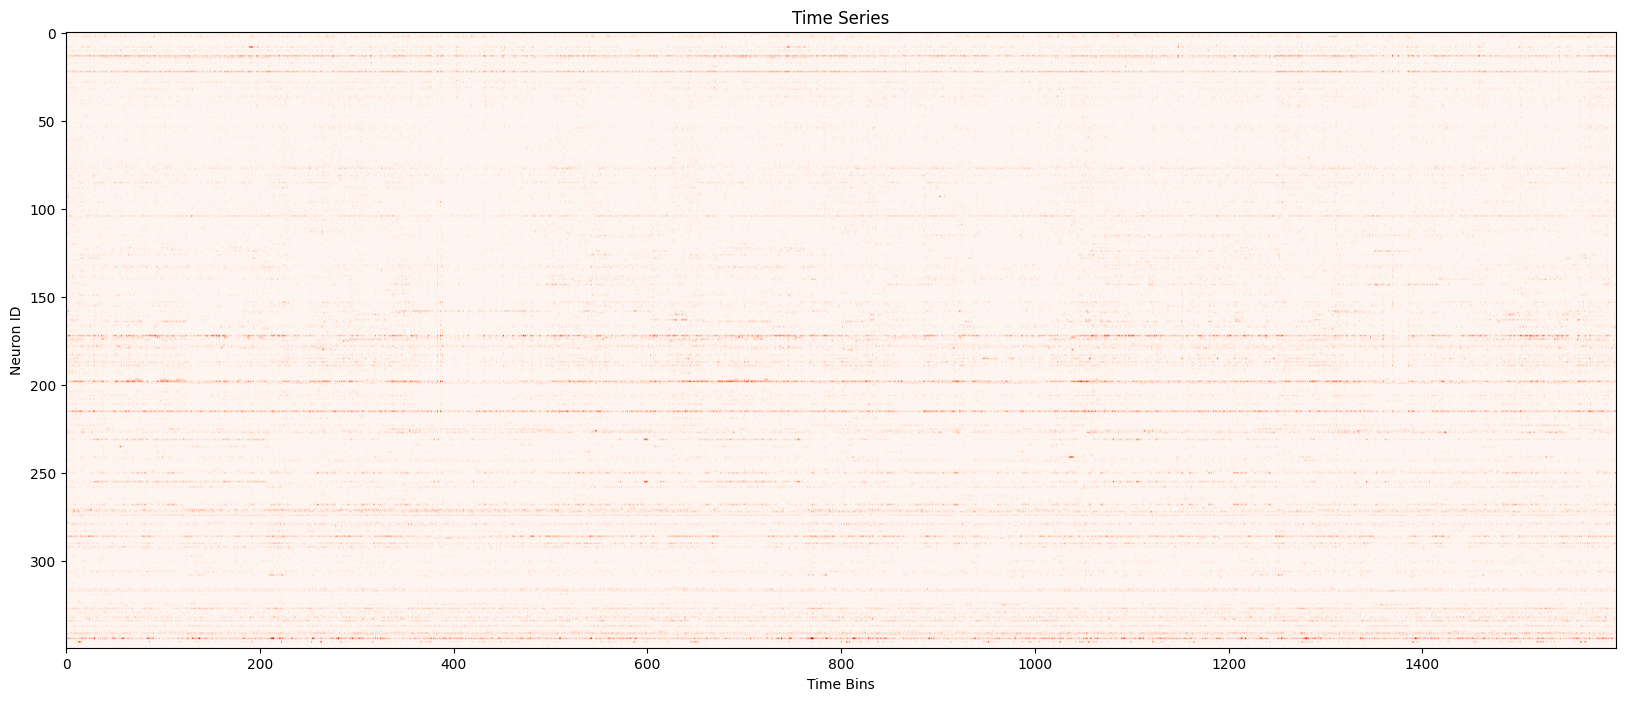

In [864]:
plt.figure(figsize=(20, 8))
plt.imshow(spike_counts[:,:1600],  cmap='Reds', aspect='auto')
plt.xlabel('Time Bins')
plt.ylabel('Neuron ID')
plt.title('Time Series')


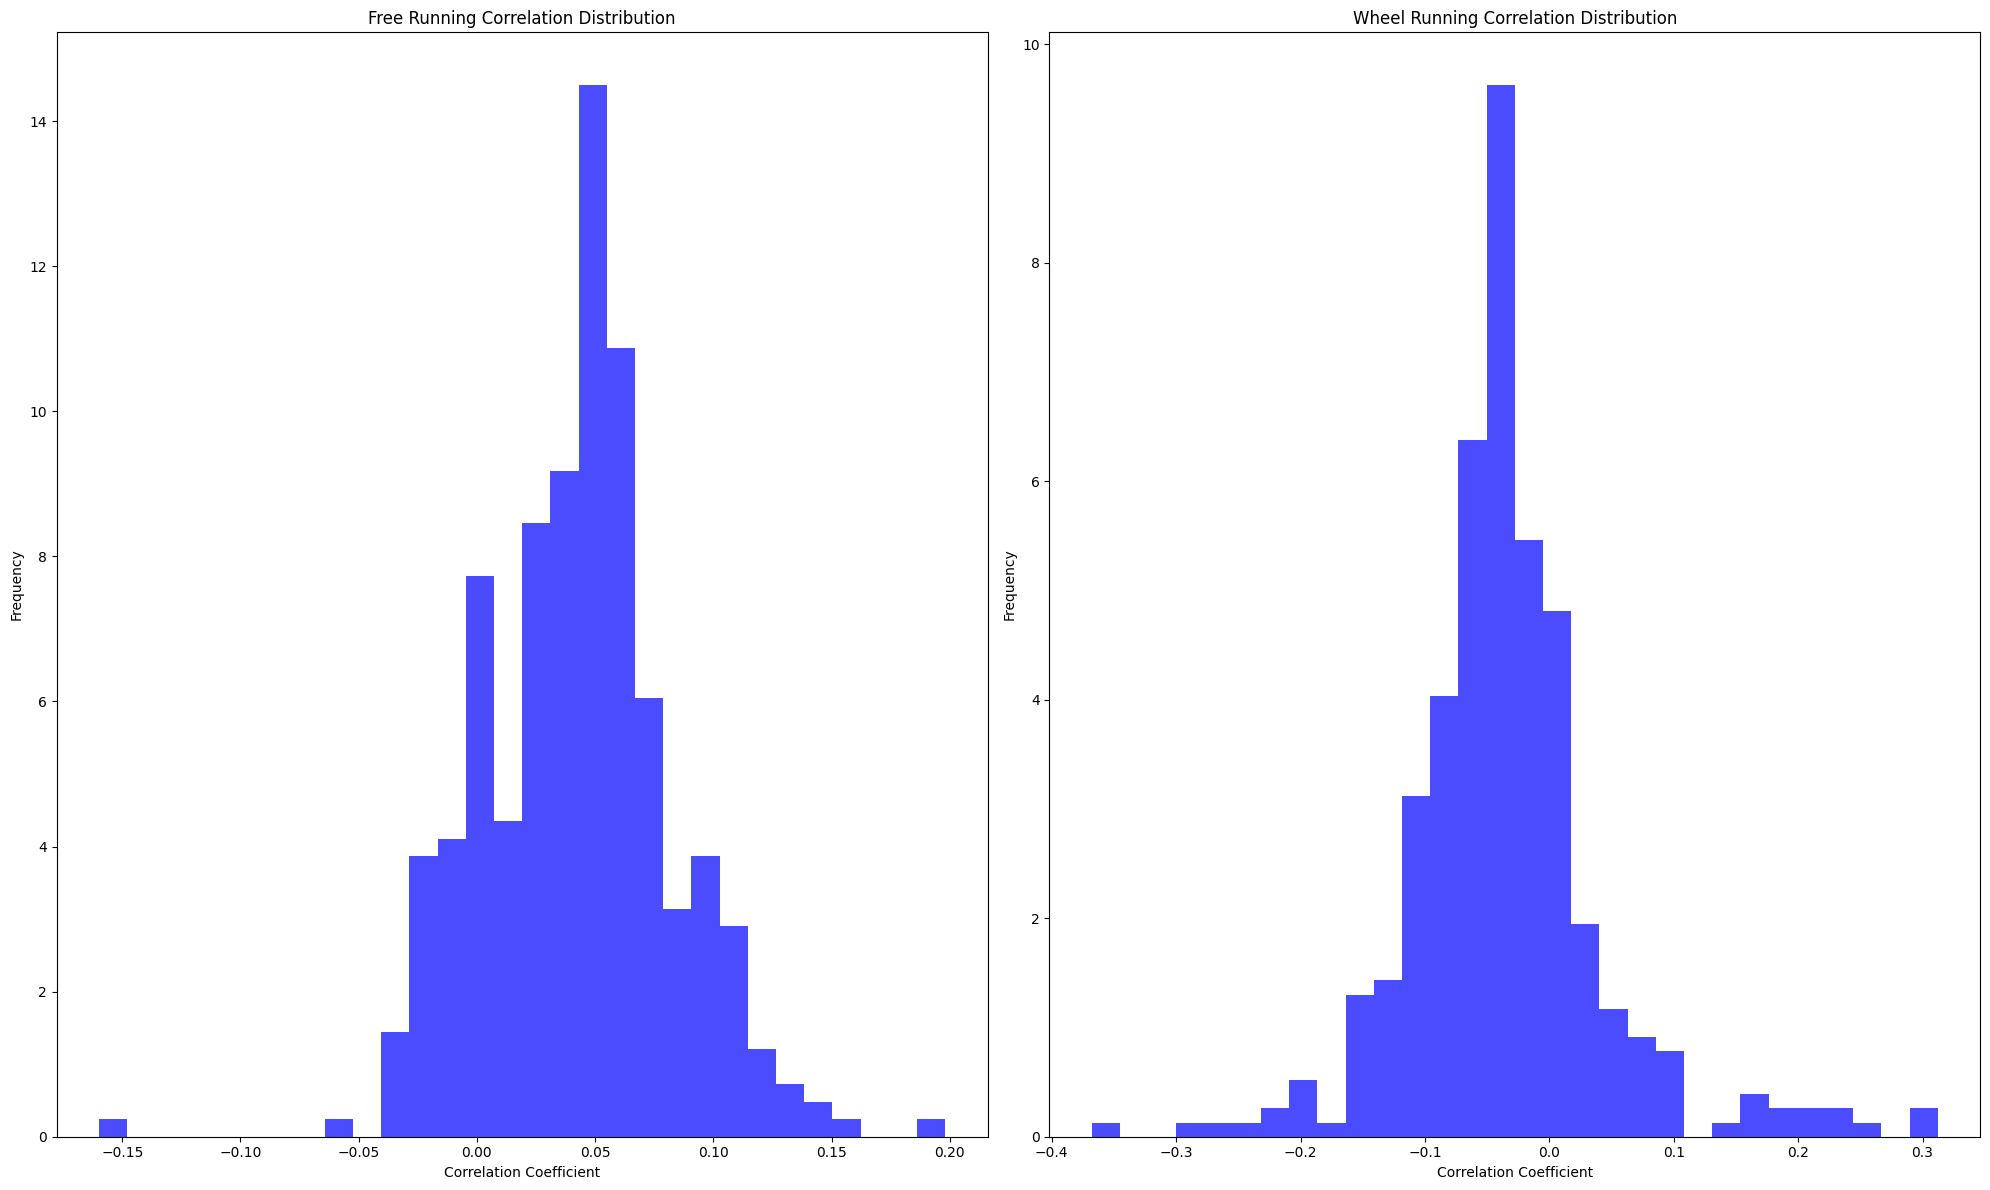

In [865]:

arena_corrs = np.zeros(spike_counts.shape[0])

wheel_corrs = np.zeros(spike_counts.shape[0])

# Loop through neurons
for i in range(spike_counts.shape[0]):
    # Free running correlation
    corr = np.corrcoef(binned_velocity[arena_mask], spike_counts[i, arena_mask])[0, 1]
    arena_corrs[i] = corr
    
    # Wheel running correlation
    corr = np.corrcoef(binned_wheel_velocity[wheel_mask], spike_counts[i, wheel_mask])[0, 1]
    wheel_corrs[i] =  corr
    

#  plot the correlation distribution during free running
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.hist(arena_corrs, bins=30, color='blue', alpha=0.7, density=True)
plt.title('Free Running Correlation Distribution')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
plt.hist(wheel_corrs, bins=30, color='blue', alpha=0.7, density=True)
plt.title('Wheel Running Correlation Distribution')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()




In [866]:
#sort by correlation

arena_corr_sort = np.argsort(arena_corrs)[::-1]
wheel_corr_sort = np.argsort(wheel_corrs)[::-1]

# Print the sorted correlation coefficients
print("Sorted Free Running Correlation Coefficients:")
for i in range(10):
    print(f"Neuron {arena_corr_sort[i]}: {arena_corrs[arena_corr_sort[i]]}")





Sorted Free Running Correlation Coefficients:
Neuron 50: nan
Neuron 254: nan
Neuron 23: nan
Neuron 198: 0.19805275234564046
Neuron 22: 0.15226103730239351
Neuron 187: 0.14458653300276583
Neuron 215: 0.14147998272943257
Neuron 344: 0.13246858563123926
Neuron 286: 0.13194597909662367
Neuron 172: 0.12818546359147404


<Figure size 1200x800 with 0 Axes>

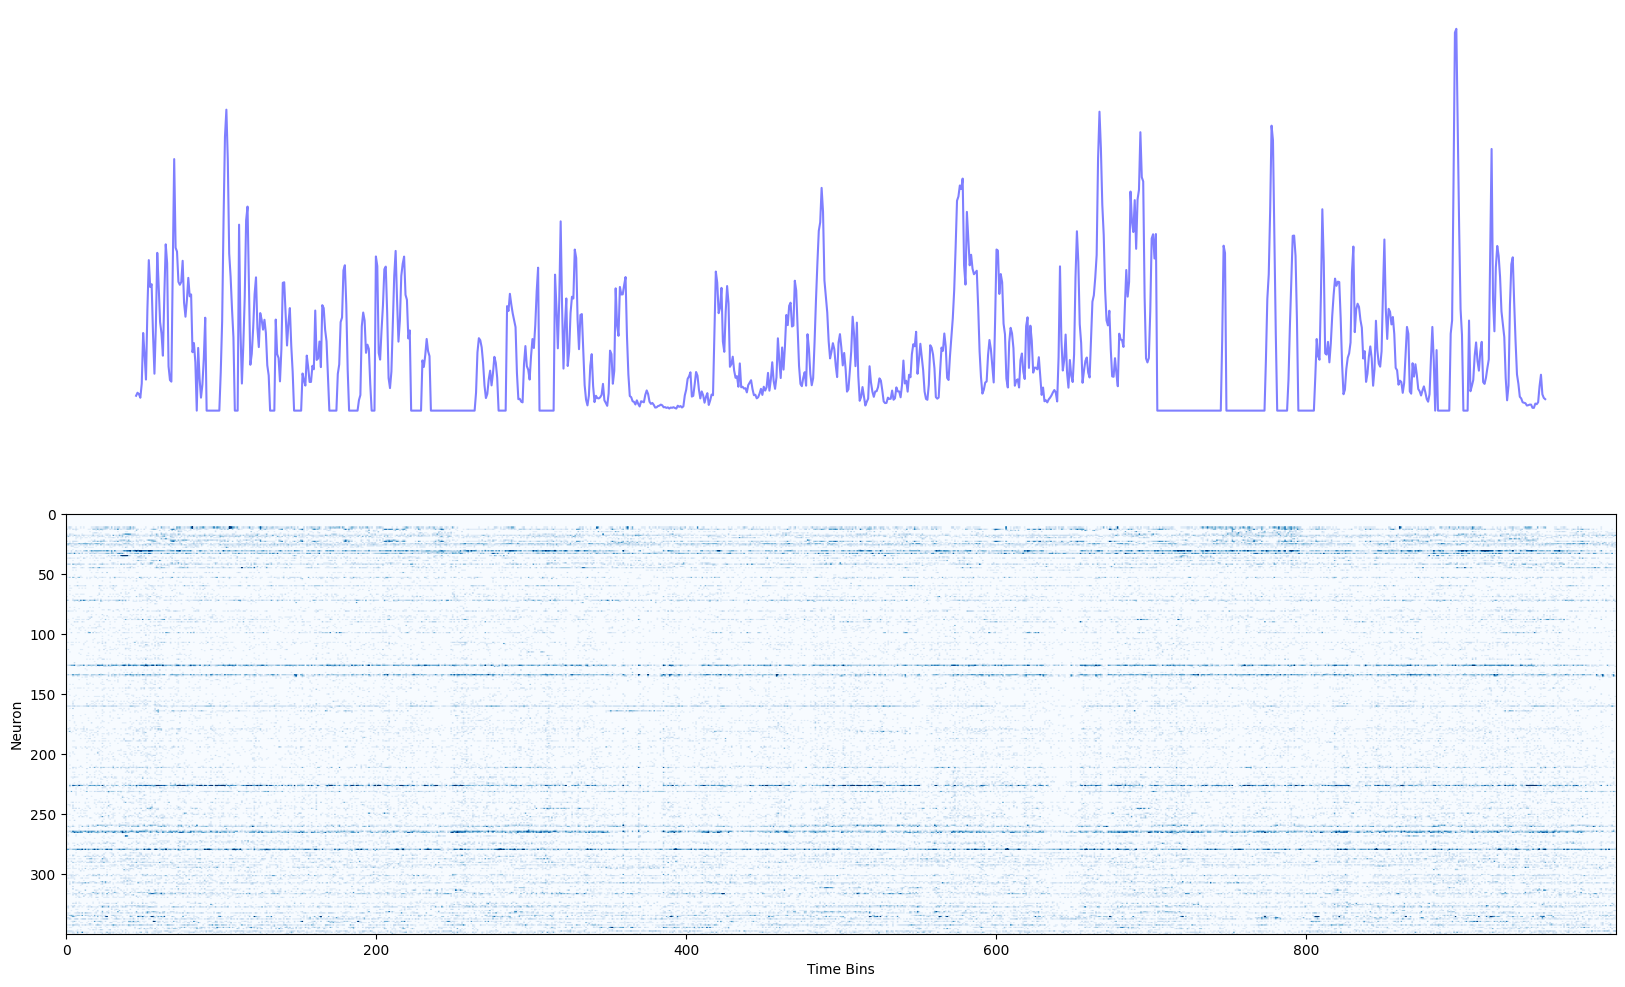

In [867]:
T_START = 1000
T_END = 2000

# Plot the binned wheel velocity and spike counts for the first 10 neurons
fig = plt.figure(figsize=(12, 8))
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(20, 12))

vel_plot = binned_velocity
vel_plot[wheel_mask] = 0

wheel_plot = binned_wheel_velocity
wheel_plot[arena_mask] = 0


ax3.plot(vel_plot[T_START:T_END], color='blue', alpha=0.5)
ax3.set_xticklabels([])  
ax3.set_xticks([])       
ax3.set_yticks([])       
ax3.spines['top'].set_visible(False)    
ax3.spines['right'].set_visible(False)  
ax3.spines['bottom'].set_visible(False) 
ax3.spines['left'].set_visible(False)

ax4.imshow(spike_counts[wheel_corr_sort,T_START:T_END], cmap='Blues',  aspect='auto', vmin=0, vmax=np.percentile(spike_counts, 99.9))
ax4.set_xlabel('Time Bins')
ax4.set_ylabel('Neuron')
plt.show()

In [868]:
print(len(vel_plot))
print(len(wheel_plot))



25585
25585


Correlation between free and wheel running neurons: 0.035929818331203796
Number of neurons excluded due to NaN: 11


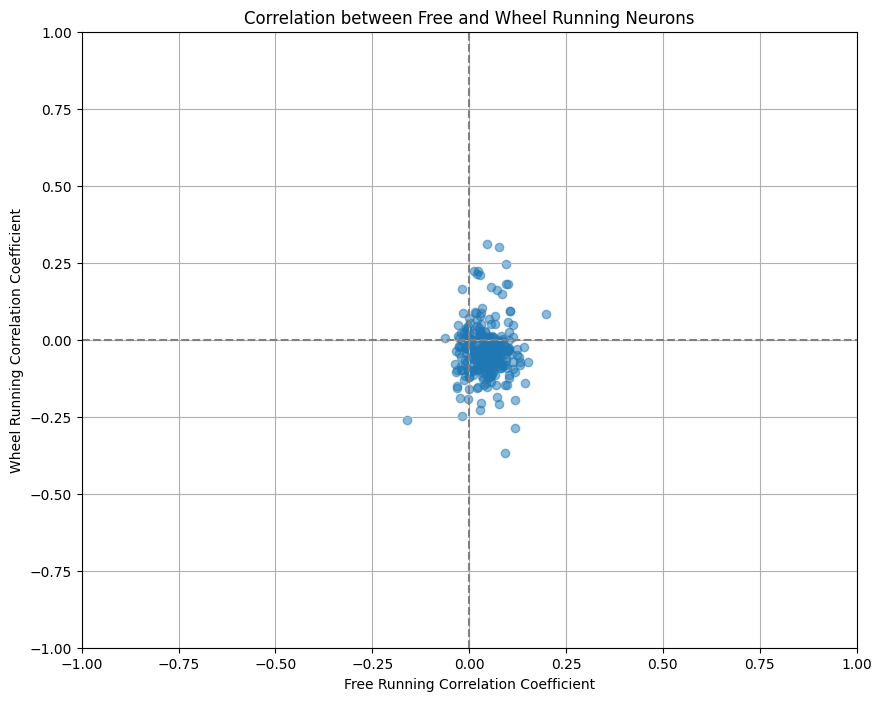

In [869]:

corrs_nan =  np.isnan(wheel_corrs) | np.isnan(arena_corrs)
wheel_corrs = wheel_corrs[~corrs_nan]
arena_corrs = arena_corrs[~corrs_nan]



id_corr = np.corrcoef(arena_corrs, wheel_corrs)[0, 1]
print(f'Correlation between free and wheel running neurons: {id_corr}')
print(f'Number of neurons excluded due to NaN: {np.sum(corrs_nan)}')

plt.figure(figsize=(10, 8))
plt.scatter(arena_corrs, wheel_corrs, alpha=0.5)
plt.xlabel('Free Running Correlation Coefficient')
plt.ylabel('Wheel Running Correlation Coefficient')
plt.title('Correlation between Free and Wheel Running Neurons')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.show()



(44910,)
(5231,)
